# Subsection 6.1 Intro to the taxi green dataset



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, roc_auc_score, f1_score
from lightgbm import LGBMRegressor, LGBMClassifier,plot_importance
from scipy.stats import mode
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Read data from url
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2016-12.parquet"
columns = ['lpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'trip_distance', 'VendorID', 'fare_amount', 'tip_amount']
data = pd.read_parquet(url, columns=columns)  # ignore the "total amount"

In [ ]:
data

,lpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,VendorID,fare_amount,tip_amount
0,2016-12-01 00:13:25,225,65,2.79,2,11.0,0.00
1,2016-12-01 00:06:47,255,255,0.45,2,3.5,0.96
2,2016-12-01 00:29:45,41,42,1.20,1,6.0,0.00
3,2016-12-01 00:05:43,80,255,1.40,1,6.5,0.00
4,2016-12-01 00:47:13,255,189,3.50,1,13.5,3.70
...,...,...,...,...,...,...,...
1224153,2016-12-31 23:30:44,145,129,3.60,2,14.0,3.82
1224154,2016-12-31 23:06:19,97,89,2.63,2,13.5,0.00
1224155,2016-12-31 23:28:06,188,190,1.29,2,7.0,0.00
1224156,2016-12-31 23:05:35,116,244,1.00,1,6.5,1.00


In [ ]:
# Data cleaning and preprocessing
data = data.sort_values('lpep_pickup_datetime').reset_index(drop=True)
categorical_columns = ['PULocationID', 'DOLocationID', 'VendorID']
data[categorical_columns] = data[categorical_columns].astype('category')
data['pickup_time'] = data['lpep_pickup_datetime'].dt.hour

In [ ]:
# Print the summary statistics
pd.set_option('display.float_format', '{:.2f}'.format)
print(data.describe())

       trip_distance  fare_amount  tip_amount  pickup_time
count     1224158.00   1224158.00  1224158.00   1224158.00
mean            2.62        11.59        1.13        13.95
std             2.81         9.79        2.22         6.54
min             0.00      -499.00      -10.56         0.00
25%             0.98         6.00        0.00        10.00
50%             1.70         9.00        0.00        15.00
75%             3.20        14.00        1.86        19.00
max           147.50      1007.00      250.70        23.00


In [ ]:
# Select numerical columns
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()


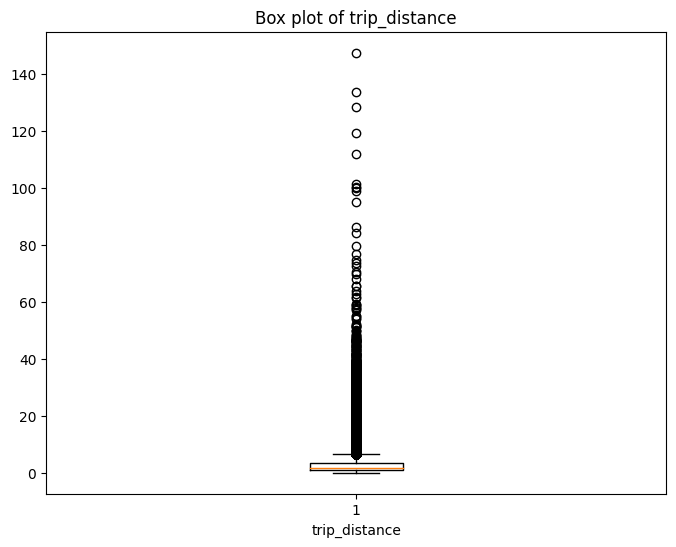

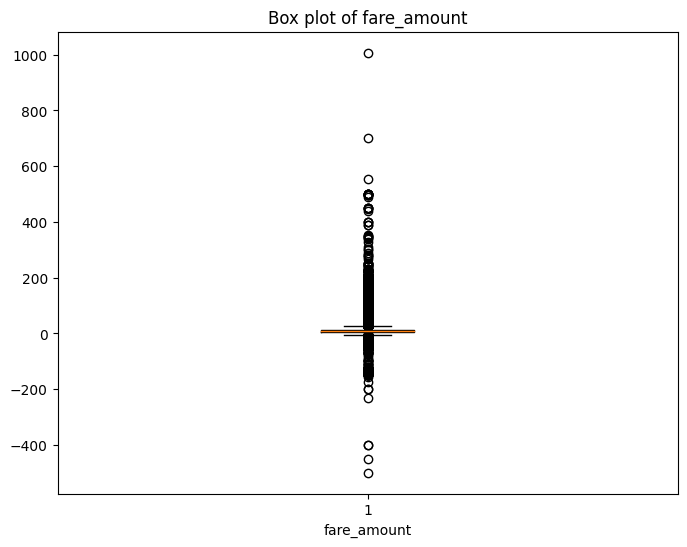

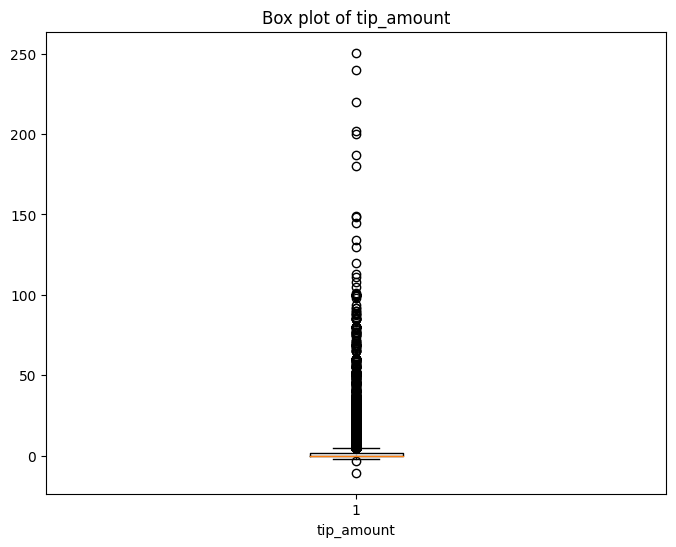

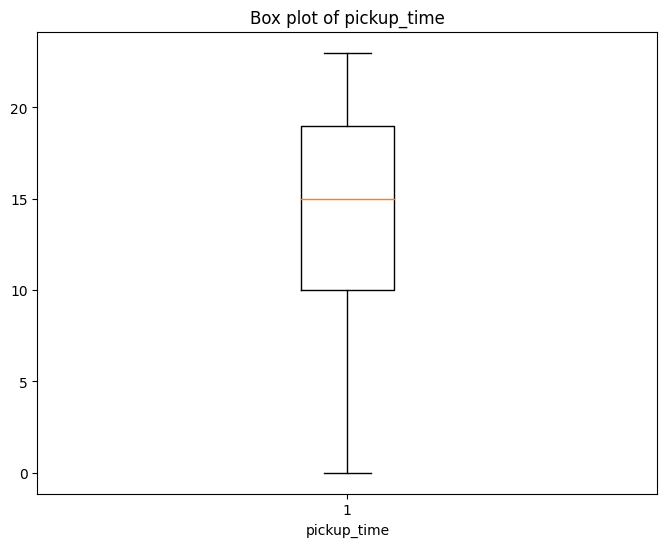

In [ ]:
# Plot box plots for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(8,6))
    plt.boxplot(data[col].dropna())  # dropna() is used to remove missing values
    plt.title(f'Box plot of {col}')
    plt.xlabel(col)
    plt.show()

In [ ]:
# Remove outliers from numerical columns
for col in numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] > lower_bound) & (data[col] < upper_bound)]

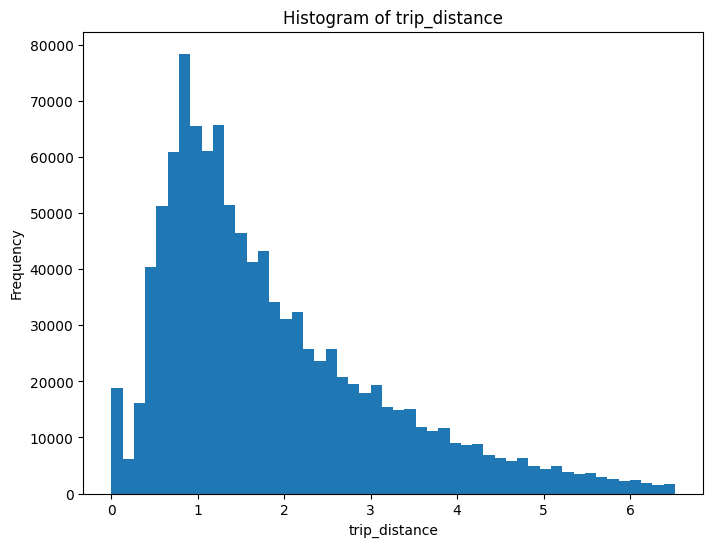

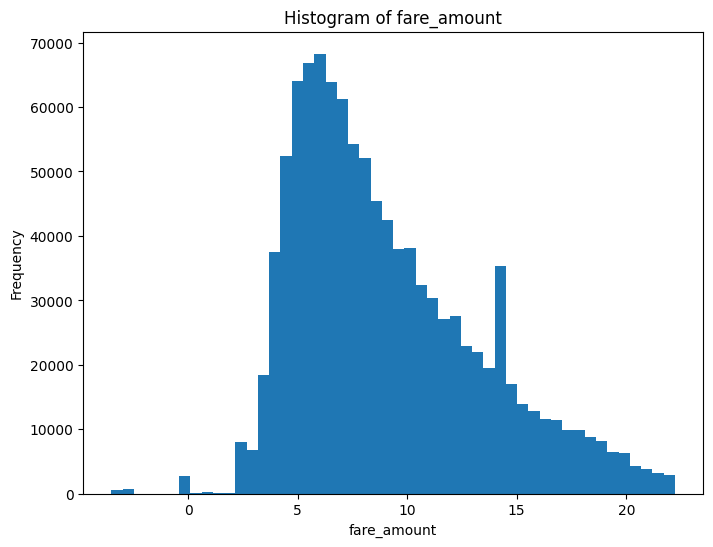

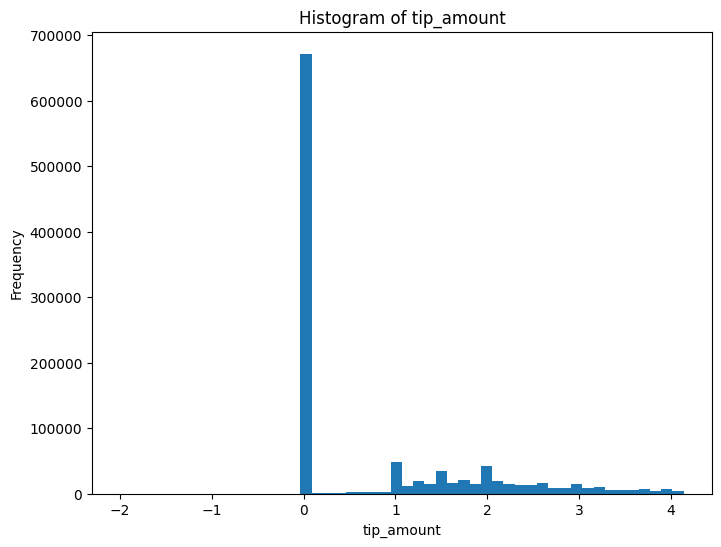

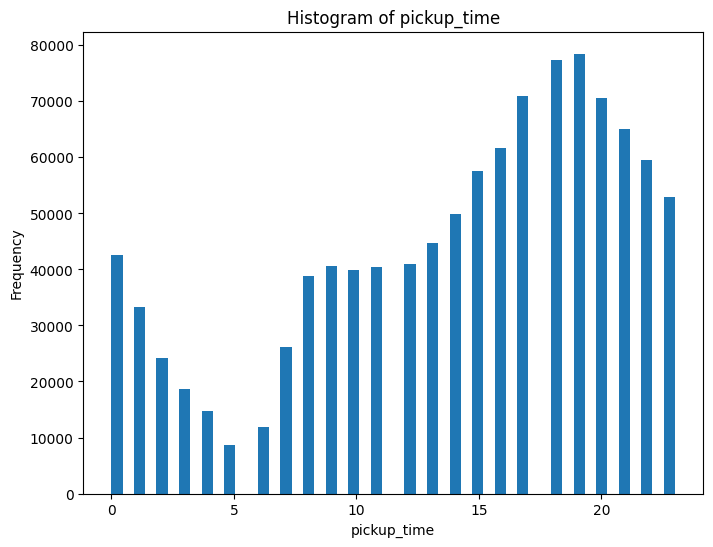

In [ ]:
# Plot histograms for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(8,6))
    plt.hist(data[col].dropna(), bins=50)  # dropna() is used to remove missing values
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


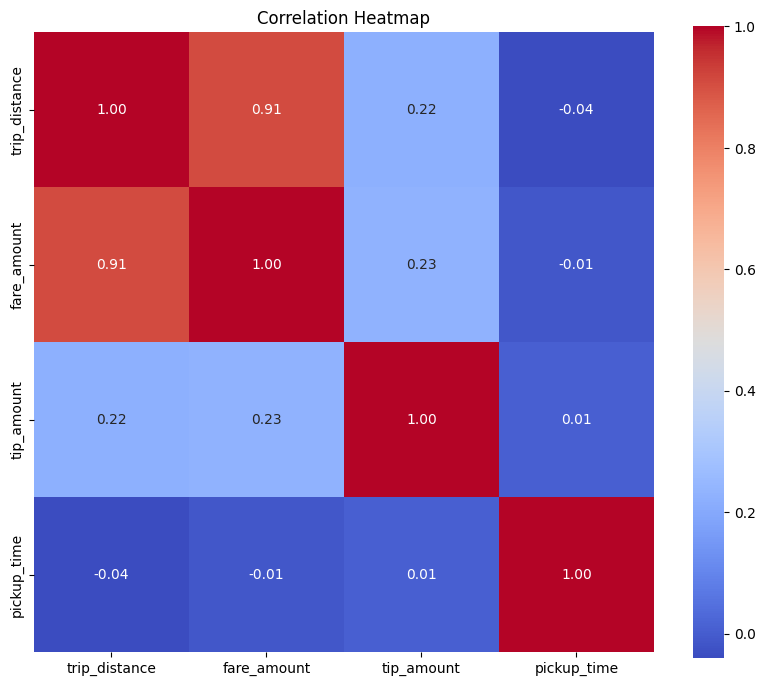

In [ ]:
# Plot correlation heatmap for numerical columns
corr = data[numerical_columns].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .82})
plt.title('Correlation Heatmap')
plt.show()


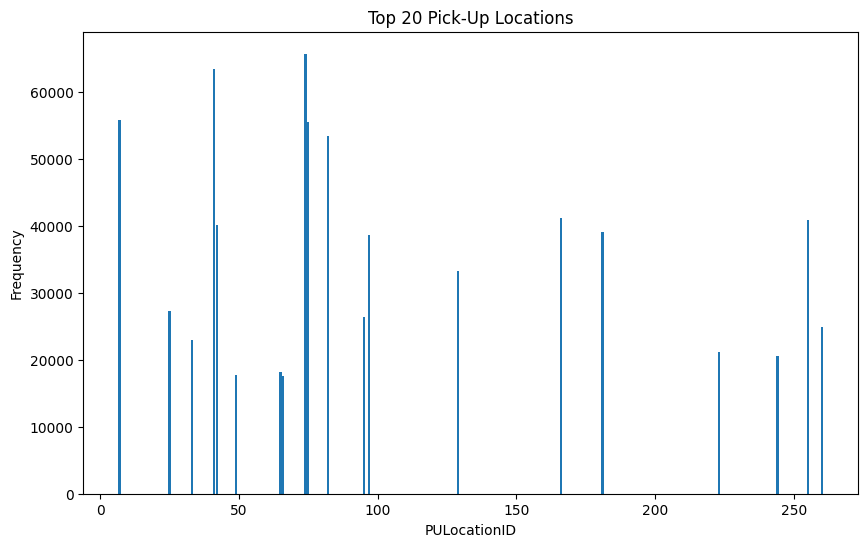

In [ ]:
# Define the number of locations to display
top_n = 20

# Calculate the frequency of each pick-up location
pu_counts = data['PULocationID'].value_counts()

# Calculate the frequency of each drop-off location
do_counts = data['DOLocationID'].value_counts()

# Create a bar plot for the top N pick-up locations
plt.figure(figsize=(10,6))
plt.bar(pu_counts.index[:top_n], pu_counts.values[:top_n])
plt.xlabel('PULocationID')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Pick-Up Locations')
plt.show()

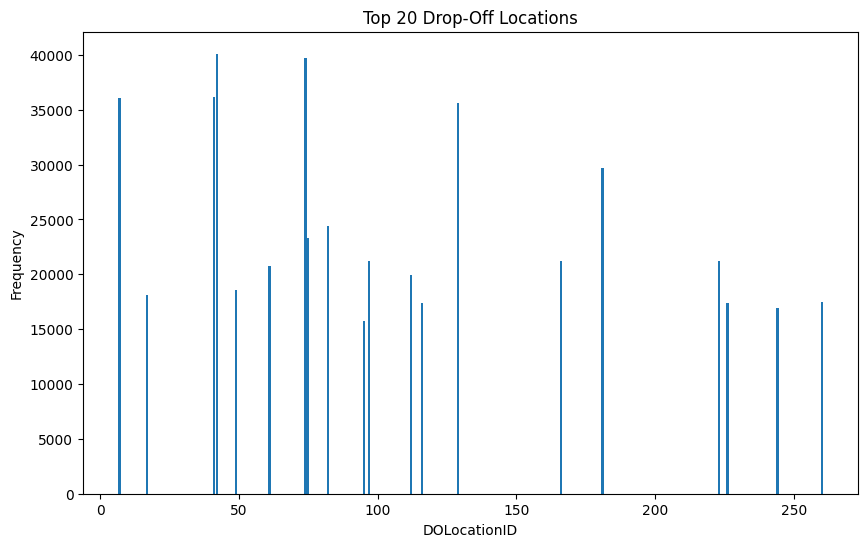

In [ ]:
# Create a bar plot for the top N drop-off locations
plt.figure(figsize=(10,6))
plt.bar(do_counts.index[:top_n], do_counts.values[:top_n])
plt.xlabel('DOLocationID')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Drop-Off Locations')
plt.show()


In [ ]:
# Get the union of the top N pick-up and drop-off locations
top_locations = set(pu_counts.index[:top_n]) | set(do_counts.index[:top_n])

# Get the frequencies of the top locations in the pick-up and drop-off data
pu_frequencies = pu_counts.loc[top_locations]
do_frequencies = do_counts.loc[top_locations]

# Create a DataFrame with the frequencies
frequencies = pd.DataFrame({
    'PULocationID': pu_frequencies,
    'DOLocationID': do_frequencies
}).fillna(0)  # Fill missing values with zero

<ipython-input-13-c5d1c66fd859>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  pu_frequencies = pu_counts.loc[top_locations]
<ipython-input-13-c5d1c66fd859>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  do_frequencies = do_counts.loc[top_locations]


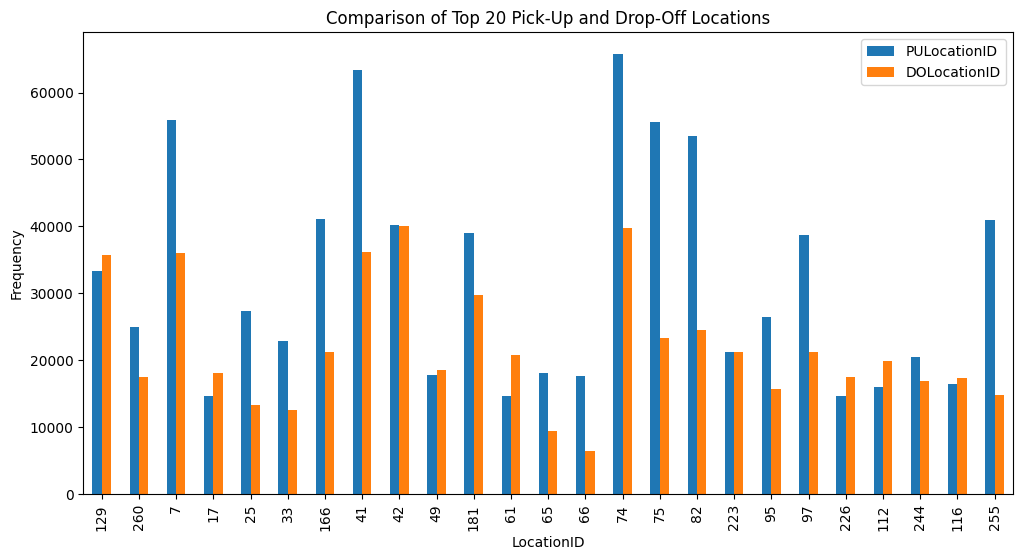

In [ ]:
# Create a bar plot
frequencies.plot(kind='bar', figsize=(12, 6))

# Add labels and title
plt.xlabel('LocationID')
plt.ylabel('Frequency')
plt.title('Comparison of Top 20 Pick-Up and Drop-Off Locations')

# Show the plot
plt.show()

# SubSection 6.2 Paritioning the data and building simple regressor and classifier


In [ ]:
# Create data partition
data['partition'] = pd.cut(
    data['lpep_pickup_datetime'],
    bins= [pd.to_datetime('2016-12-01'),
           pd.to_datetime('2016-12-08'),
           pd.to_datetime('2016-12-16'),
           pd.to_datetime('2017-01-01')],
    right=False,
    labels= ['train', 'test', 'prod']
)

## Tip amount regressor





In [ ]:
# Set target and features
target = 'tip_amount'
features = [col for col in data.columns if col not in [target, 'lpep_pickup_datetime', 'partition']]

# Split the data
X_train = data.loc[data['partition'] == 'train', features]
y_train = data.loc[data['partition'] == 'train', target]

X_test = data.loc[data['partition'] == 'test', features]
y_test = data.loc[data['partition'] == 'test', target]

X_prod = data.loc[data['partition'] == 'prod', features]
y_prod = data.loc[data['partition'] == 'prod', target]

In [ ]:
# Save the regression test data
regression_test = X_test.join(y_test)
regression_test.to_csv('regression_test.csv', index=False)

# Save the regression production data
regression_prod = X_prod
regression_prod.to_csv('regression_prod.csv', index=False)

In [ ]:
# Fit the model
model = LGBMRegressor(random_state=111)
model.fit(X_train, y_train)

LGBMRegressor(random_state=111)

In [ ]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# Measure train, test and baseline performance
mae_train = mean_absolute_error(y_train, y_pred_train).round(4)
mae_test = mean_absolute_error(y_test, y_pred_test).round(4)

mae_train_baseline = mean_absolute_error(y_train, y_pred_train_baseline).round(4)
mae_test_baseline = mean_absolute_error(y_test, y_pred_test_baseline).round(4)

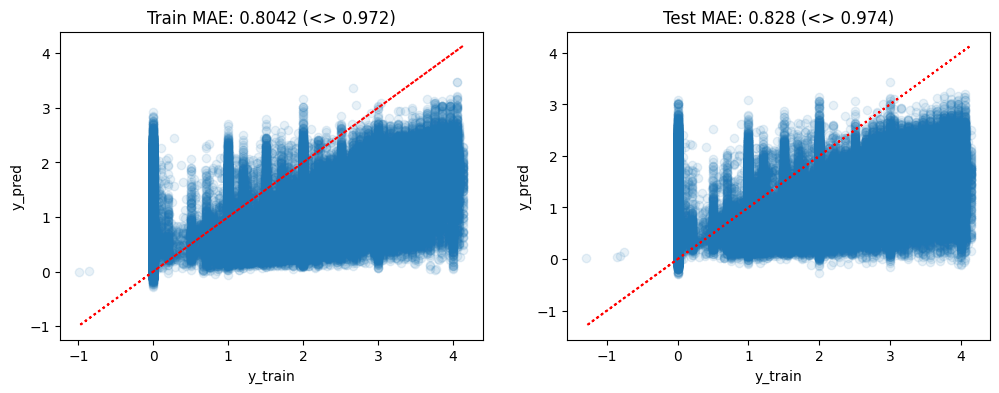

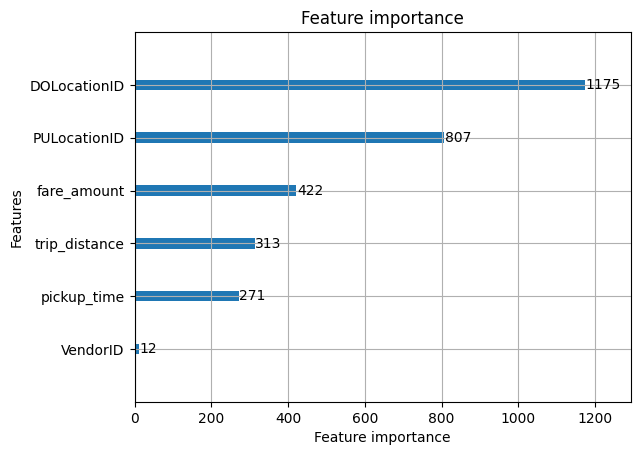

In [ ]:
# Create performance report
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

title1 = 'Train MAE: {} (<> {})'.format(mae_train, mae_train_baseline)
ax1.set(title=title1, xlabel='y_train', ylabel='y_pred')
ax1.plot(y_train, y_train, color='red', linestyle=':')
ax1.scatter(y_train, y_pred_train, alpha=0.1)

title2 = 'Test MAE: {} (<> {})'.format(mae_test, mae_test_baseline)
ax2.set(title=title2, xlabel='y_train', ylabel='y_pred')
ax2.plot(y_test, y_test, color='red', linestyle=':')
ax2.scatter(y_test, y_pred_test, alpha=0.1)

plt.show()

fig, ax = plt.subplots()
plot_importance(model, ax=ax)
plt.show()

In [ ]:
#Predicting in production
y_pred_prod = model.predict(X_prod)


In [ ]:
# Create a DataFrame with the target and timestamp from the production data
regression_targets = pd.DataFrame({
    'target': y_prod,
    'timestamp': data.loc[data['partition'] == 'prod', 'lpep_pickup_datetime']
}).reset_index(drop=True)

In [ ]:
# Save the DataFrame to a CSV file
regression_targets.to_csv('regression_targets.csv', index=False)


## Tip/No Tip classifier


In [ ]:
# Creating a binary target variable
data['tip_given'] = np.where(data['tip_amount'] > 0, 1, 0)

# Set target and features for the classification model
target_clf = 'tip_given'


In [ ]:
# Split the data for the classification model
X_train_clf = data.loc[data['partition'] == 'train', features]
y_train_clf = data.loc[data['partition'] == 'train', target_clf]

X_test_clf = data.loc[data['partition'] == 'test', features]
y_test_clf = data.loc[data['partition'] == 'test', target_clf]

X_prod_clf = data.loc[data['partition'] == 'prod', features]
y_prod_clf = data.loc[data['partition'] == 'prod', target_clf]

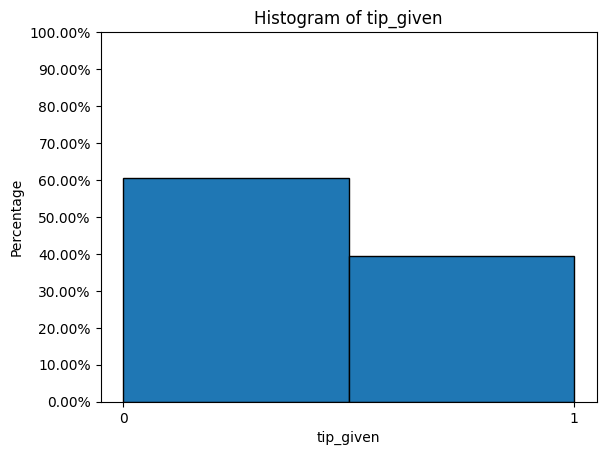

In [ ]:
# Compute the total number of instances
n_total = len(y_train_clf)

# Plot a histogram for the binary target
weights = np.ones_like(y_train_clf) / n_total
plt.hist(y_train_clf, bins=2, edgecolor='black', weights=weights)

# Set the x-ticks to be 0 and 1
plt.xticks([0,1])

# Set the y-ticks to represent percentages, with 2 decimal places
plt.yticks(np.arange(0, 1.1, 0.1), [f"{i*100:.2f}%" for i in np.arange(0, 1.1, 0.1)])

# Limit the y-axis to 0.0 and 1.0 (or 0% and 100%)
plt.ylim([0.0, 1.0])

# Set the x and y axis labels
plt.xlabel('tip_given')
plt.ylabel('Percentage')

# Set the title of the plot
plt.title('Histogram of tip_given')

# Display the plot
plt.show()

In [ ]:
# Save the classification test data
classification_test = X_test_clf.join(y_test_clf)
classification_test.to_csv('classification_test.csv', index=False)

# Save the classification production data
classification_prod = X_prod_clf
classification_prod.to_csv('classification_prod.csv', index=False)


In [ ]:
# Fit the model
model_clf = LGBMClassifier(random_state=111)
model_clf.fit(X_train_clf, y_train_clf)


LGBMClassifier(random_state=111)

In [ ]:
# Make predictions
y_pred_train_clf = model_clf.predict(X_train_clf)
y_pred_test_clf = model_clf.predict(X_test_clf)

# Make baseline predictions as the most frequent class
majority_class = y_train_clf.value_counts().idxmax()
y_pred_train_baseline_clf = [majority_class] * len(y_train_clf)
y_pred_test_baseline_clf = [majority_class] * len(y_test_clf)

In [ ]:
## Measure train and test performance using F1 score for the model and the baseline
f1_train = f1_score(y_train_clf, y_pred_train_clf).round(4)
f1_test = f1_score(y_test_clf, y_pred_test_clf).round(4)
f1_train_baseline = f1_score(y_train_clf, y_pred_train_baseline_clf).round(4)
f1_test_baseline = f1_score(y_test_clf, y_pred_test_baseline_clf).round(4)

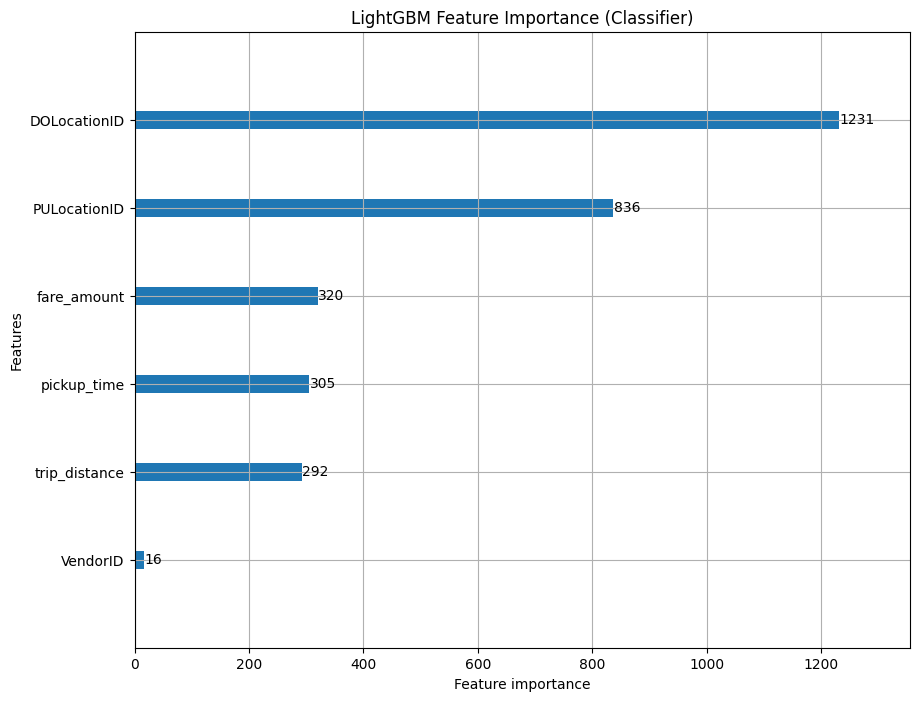

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the feature importance
plot_importance(model_clf, ax=ax, importance_type='split')

# Set the title of the plot
plt.title("LightGBM Feature Importance (Classifier)")

# Display the plot
plt.show()

In [ ]:
# Measure train, test and baseline performance
roc_auc_train = roc_auc_score(y_train_clf, y_pred_train_clf)
roc_auc_test = roc_auc_score(y_test_clf, y_pred_test_clf)

roc_auc_train_baseline = roc_auc_score(y_train_clf, y_pred_train_baseline_clf)
roc_auc_test_baseline = roc_auc_score(y_test_clf, y_pred_test_baseline_clf)

# Create performance report
print(f'Train ROC AUC: {roc_auc_train} (Baseline <> {roc_auc_train_baseline})')
print(f'Test ROC AUC: {roc_auc_test} (Baseline <> {roc_auc_test_baseline})')

Train ROC AUC: 0.663218627942357 (Baseline <> 0.5)
Test ROC AUC: 0.643899591929624 (Baseline <> 0.5)


In [ ]:
# Get predicted probabilities for the production data
y_pred_prod_prob = model_clf.predict_proba(X_prod_clf)[:, 1]

# Create a DataFrame with the target, predicted probabilities and timestamp from the production data
classification_targets = pd.DataFrame({
    'target': y_prod_clf,
    'predicted_probability': y_pred_prod_prob,
    'timestamp': data.loc[data['partition'] == 'prod', 'lpep_pickup_datetime']
})

# Reset the index of the DataFrame
classification_targets = y_prod_clf.reset_index(drop=True)

In [ ]:
classification_targets.to_csv('classification_targets.csv', index=False)